In [1]:
# Example of fitting double-slit diffraction data
# Version using lmfit, see https://lmfit.github.io/lmfit-py/index.html

In [2]:
from pathlib import Path
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm

In [3]:
import diffraction as dif

In [4]:
slit_width = 0.1
slit_separation = 0.3
aperture_width = 10.
N = 3000
λ = 532e-6 # frequency doubled Nd-YAG laser
z = 15*25.4 # screen distance

In [5]:
U_aperture, x_aperture = dif.two_slit(slit_width,slit_separation,aperture_width,N)

In [6]:
U_screen, x_screen, F_number = dif.fresnel_1d(U_aperture, aperture_width, λ, z)

In [7]:
F_number

np.float64(1.3822728154997477)

Text(0.5, 1.0, 'Two-slit Fresnel pattern\nw=100.0 μm, Δ=300.0 μm, z=38.1 cm, λ=532.0 nm')

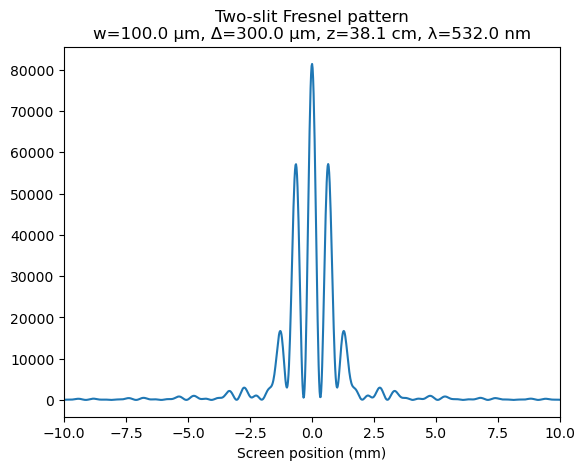

In [12]:
fig, ax = plt.subplots()
ax.plot(x_screen, np.abs(U_screen)**2)
ax.set_xlabel("Screen position (mm)")
ax.set_xlim(-10,10)
ax.set_title(f"Two-slit Fresnel pattern\nw={slit_width*1e3:.1f} μm, Δ={slit_separation*1e3:.1f} μm, z={z/10:.1f} cm, λ={λ*1e6:.1f} nm")

In [18]:
datafile = Path('data/double slit 15ish inches green laser.csv')

In [19]:
# read the datafile and convert to a numpy array with the right shape
with open(datafile) as file:
    reader = csv.reader(file)
    data = [i for i in reader]

data = np.array(data).astype(float).T

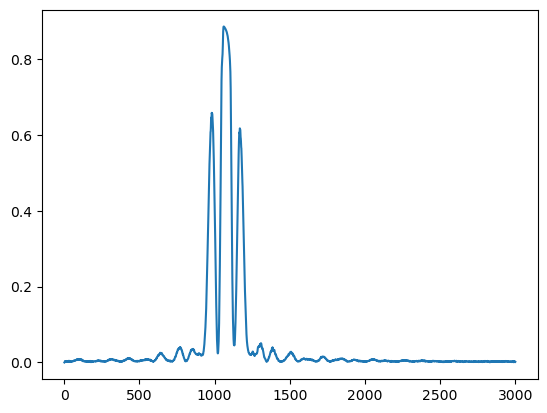

In [20]:
plt.plot(data[0],data[1])

In [13]:
def fit_function(x,slit_width,slit_separation,z,screen_width,δN,λ,N):
    # estimate array_width from the screen_width using Fraunhofer approx
    array_width = N * z/ screen_width * λ
    U_a, _ = dif.two_slit(slit_width, slit_separation, array_width, N)
    U_s, x = dif.fresnel_1d(U_a, array_width, λ, z)
    I_temp = np.abs(U_s)**2
    #! FIXME need to shift and scale I_screen, probably using sampling tricks
    I_screen = I_temp
    return I_screen


In [7]:
# create an lmfit model:
fit_model = lm.Model(fit_function)
fit_params = fit_model.make_params()

In [8]:
# save our initial guesses (only the guess value is required, but I'm including the optional values for completeness)
fit_params['a'].set(0.0315, min = 0,     max = np.inf, vary=True)
fit_params['b'].set(0.9,    min = 0,     max = np.inf, vary=True)
fit_params['c'].set(0.0125, min =0,      max = np.inf, vary=True)
fit_params['d'].set(1075,   min=0,       max=3000,     vary=True)
fit_params['f'].set(0,      min=-np.inf, max=np.inf,   vary=True)

In [9]:
fit_params

name,value,initial value,min,max,vary
a,0.03150000,0.0315,0.00000000,inf,True
b,0.90000000,0.9,0.00000000,inf,True
c,0.01250000,0.0125,0.00000000,inf,True
d,1075.00000,1075,0.00000000,3000.00000,True
f,0.00000000,0,-inf,inf,True


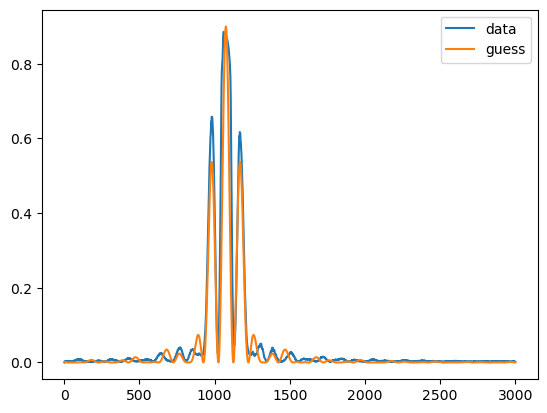

In [10]:
# Michael's best guess
guess = [0.0315,0.9,0.0125,1075,0]

fig, ax = plt.subplots()
ax.plot(data[0],data[1],label='data')
ax.plot(data[0],fit_function(data[0],*guess),label='guess')
ax.legend()

In [11]:
fit_result = fit_model.fit(data[1],fit_params,x=data[0],nan_policy='omit',method='leastsq') # 'leastsq' is the default method

In [12]:
fit_result

Text(0.5, 0.98, 'Results using lmfit')

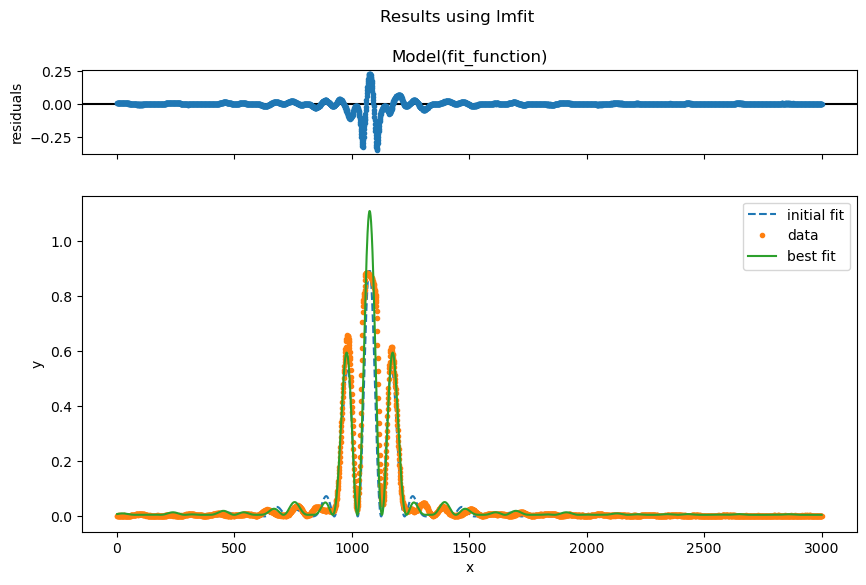

In [14]:
fig = fit_result.plot(datafmt='.',
                  show_init=True,
                  fig_kws={'figsize':(10,6)})
fig.suptitle("Results using lmfit")